In [1]:
import xarray as xr
import rioxarray

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
base_filepath = 'C:/Users/steve/OneDrive/Documents/School Stuff/UW/Mountain Hydrology Research Group/Snow Sensor Usability Paper - Passive Microwave/Data/'

In [3]:
def cdf(data):
    # compute cdf values for a 1D array of data
    data = data[~np.isnan(data)] # remove NaN values
    x = np.sort(data) #sort data
    y = 1. * np.arange(len(data)) / (len(data) - 1) #calculate CDF values
    return x, y

In [4]:
def mountain_mask(ds, resampling=5):
    '''Given a dataset (ds), create a mountain mask from the MODIS Mountain Snow Classes map using reproject match.
       Use resampling=0 for nearest neighbor (when 1km mountain mask is coarser spatial resolution than target dataset)
       Use resampling=5 for average (when 1km mountain mask is finer spatial resolution than target dataset)
       More options and details here: https://rasterio.readthedocs.io/en/stable/api/rasterio.enums.html#rasterio.enums.Resampling'''
    
    # open the mountain mask file
    mtnsnow_classes = xr.open_rasterio(base_filepath + 'MODIS_mtnsnow_classes/MODIS_mtnsnow_classes.tif').squeeze()
    
    # Clip to North America to match spatial extent of NoahMP models (Longitudes: -169 to -51, Latitudes: 24 to 72)
    min_lon, max_lon = -169, -51
    min_lat, max_lat = 24, 72
    mtnsnow_classes = mtnsnow_classes.rio.clip_box(minx=min_lon, miny=min_lat, maxx=max_lon, maxy=max_lat)
    
    # set values that are 256 (the nodata value) to zero before resampling
    mtnsnow_classes = mtnsnow_classes.where(mtnsnow_classes!=256, 0)
    
    # resample to match target dataset (ds) spatial resolution
    mtnsnow_classes_rpr = mtnsnow_classes.rio.reproject_match(ds, resampling=resampling)
    
    # create the mountain mask by finding all non-zero pixels, these are mountains
    mtn_mask = mtnsnow_classes_rpr.where(mtnsnow_classes_rpr>0).isnull()
    
    return mtn_mask

In [5]:
# read in TCC geotiff
tcc = xr.open_rasterio(base_filepath + 'forest_cover/global_forest_change_2019_v1_7.treecover2000.tif').squeeze()

# replace zero values with NaNs
tcc = tcc.where(tcc != 0)

# apply the mountain mask
tcc = tcc.where(mountain_mask(tcc).values)

# compute TCC CDF
tcc_cdf_x, tcc_cdf_y = cdf(tcc.values.ravel())

# convert to a pandas dataframe
tcc_cdf_df = pd.DataFrame(data={'cdf_x': tcc_cdf_x, 'cdf_y': tcc_cdf_y})

# export CDF values to a csv file
tcc_cdf_df.to_csv('tcc_CDF.csv')

In [6]:
# read in MODIS LAI February mean geotiff
lai = xr.open_rasterio(base_filepath + 'forest_cover/Lai_sf01.tif').squeeze()

# replace nodata values (values > 100) with NaNs
lai = lai.where(lai <= 100)
# replace zero values with NaNs
lai = lai.where(lai != 0)

# apply the mountain mask
lai = lai.where(mountain_mask(lai).values)

# compute LAI CDF
lai_cdf_x, lai_cdf_y = cdf(lai.values.ravel())

# convert to a pandas dataframe
lai_cdf_df = pd.DataFrame(data={'cdf_x': lai_cdf_x, 'cdf_y': lai_cdf_y})

# export CDF values to a csv file
lai_cdf_df.to_csv('lai_CDF.csv')

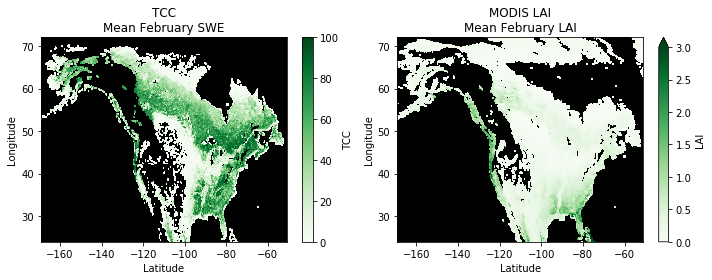

In [7]:
### Map plots ###
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,4),tight_layout=True,gridspec_kw={'width_ratios': [1, 1]})
[ax1, ax2] = ax.ravel()

# TCC map
tcc.plot(ax=ax1, vmin=0, vmax=100, cmap='Greens', cbar_kwargs={'label': 'TCC'})

# LAI map
lai.plot(ax=ax2, vmin=0, vmax=3, cmap='Greens', cbar_kwargs={'label': 'LAI'})


# format map plots
ax1.set_title('TCC\nMean February SWE')
ax2.set_title('MODIS LAI\nMean February LAI')

for this_ax in ax:
    this_ax.set_ylim(24,72)
    this_ax.set_ylabel('Longitude')
    this_ax.set_xlabel('Latitude')
    this_ax.set_facecolor("black")

# save figure
plt.savefig('northamerica-forest-maps-mountainsmasked.jpg')

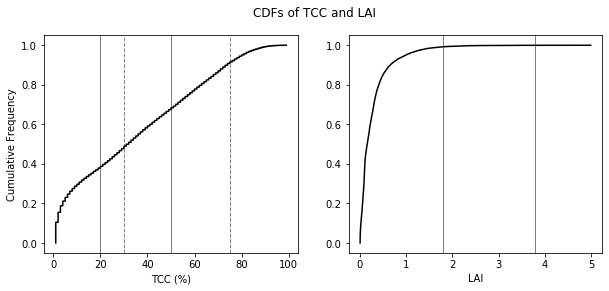

In [8]:
### CDF plot ###
fig, [ax, ax2] = plt.subplots(nrows=1,ncols=2,figsize=(10,4),tight_layout=False)

#ax2 = ax.twiny() # make second x axis

# TCC CDF
ax.plot(tcc_cdf_x, tcc_cdf_y, '-', c='k', label='TCC')
# add vertical lines for TCC thresholds
ax.axvline(20, c='grey', linestyle='-', lw=1, zorder=-99)
ax.axvline(30, c='grey', linestyle='--', lw=1, zorder=-99)
ax.axvline(50, c='grey', linestyle='-', lw=1, zorder=-99)
ax.axvline(75, c='grey', linestyle='--', lw=1, zorder=-99)

# LAI CDF
ax2.plot(lai_cdf_x, lai_cdf_y, '-', c='k', label='MODIS LAI')
# add vertical lines for LAI thresholds
ax2.axvline(1.8, c='grey', lw=1, zorder=-99)
ax2.axvline(3.8, c='grey', lw=1, zorder=-99)
# format CDF plot
#ax.set_xlim((-5,100))
fig.suptitle('CDFs of TCC and LAI')
ax.set_ylabel('Cumulative Frequency')
ax.set_xlabel('TCC (%)')
ax2.set_xlabel('LAI')
#ax.legend(loc=(.75,.25), frameon=False);
#ax2.legend(loc=(.75,.18), frameon=False);

# save figure
plt.savefig('northamerica-forest-cdfs-mountainsmasked.jpg')